In [2]:
from pcapng import FileScanner
from pcapng.blocks import EnhancedPacket
from utils import packet_state
from capture_process import PicklableEnhancedPacket
import graphviz



--------------------- State Machine ---------------------
[Machine] Global Config Loaded: global_config.json
[Machine] Final Config Loaded: /home/user/wdissector/configs/bt_config.json
Disabling Core dump for this process: ulimit -c 0
WDissector Lib (Wireshark) 4.1.0 (v4.1.0rc0-673-g3baf3216acca)
Profile "WDissector" loaded
[Machine] Mapping Rules loaded: 9
[Machine] --> "btsdp"
[Machine] --> "bta2dp"
[Machine] --> "btavrcp"
[Machine] --> "btavdtp"
[Machine] --> "btrfcomm"
[Machine] --> "btl2cap"
[Machine] --> "btbrlmp.op == 3"
[Machine] --> "esp32_btlmp"
[Machine] --> "fhs"
[Machine] Exclusion Rules loaded: 4
[Machine] Event loop started
[Machine] Global Config Loaded: global_config.json
[Machine] Final Config Loaded: /home/user/wdissector/bindings/python/configs/bt_config.json
WDissector Lib (Wireshark) 4.1.0 (v4.1.0rc0-673-g3baf3216acca)
Profile "WDissector" loaded
[Machine] Mapping Rules loaded: 9
[Machine] --> "btsdp"
[Machine] --> "bta2dp"
[Machine] --> "btavrcp"
[Machine] --> 

In [3]:
from traceback import print_exc


capture_path = "captures/capture_bluetooth_duplicated_iocap_22jan.pcapng"
with open(capture_path, "rb") as f:
    pkts = []
    prev_pkt = None
    crash_idx = 0
    current_iteration = 0
    pkt_idx = 1  # for the ease of wireshark use and reference, start from 1

    scanner = FileScanner(f)
    try:
        for idx, block in enumerate(scanner):
            if not isinstance(block, EnhancedPacket):
                continue
            # TODO: detect packet direction
            pkt_state = packet_state(block.packet_data)
            pkt_comment = block.options.get("opt_comment")
            if b"BT Process Started" in block.packet_data:
                current_iteration += 1
            elif pkt_comment == "Fuzzed from previous":
                pkts.append(
                    {
                        "pkt": PicklableEnhancedPacket(block),
                        "pkt_loc": pkt_idx,
                        "iteration": current_iteration,
                        "prev_pkt": PicklableEnhancedPacket(prev_pkt),
                        "scanner_loc": idx,
                        "state": pkt_state,
                        "type": "mutation",
                        "direction": "RX"
                        if block.packet_data[3:4] == b"\x01"
                        else "TX",
                    }
                )
            elif pkt_comment is not None and "Duplicated" in pkt_comment:
                pkts.append(
                    {
                        "pkt": PicklableEnhancedPacket(block),
                        "pkt_loc": pkt_idx,
                        "iteration": current_iteration,
                        "prev_pkt": PicklableEnhancedPacket(prev_pkt),
                        "scanner_loc": idx,
                        "state": pkt_state,
                        "type": "duplication",
                        "direction": "RX"
                        if block.packet_data[3:4] == b"\x01"
                        else "TX",
                    }
                )
            elif block.packet_data[4:13] == b"\n\xfa[Crash]":
                break
            elif block.packet_data[4:6] != b"\x0a\xfc":
                pkts.append(
                    {
                        "pkt": PicklableEnhancedPacket(block),
                        "pkt_loc": pkt_idx,
                        "iteration": current_iteration,
                        "scanner_loc": idx,
                        "state": pkt_state,
                        "type": "normal",
                        "direction": "RX"
                        if block.packet_data[3:4] == b"\x01"
                        else "TX",
                    }
                )

            pkt_idx += 1
            prev_pkt = block
    except Exception as e:
        print_exc(e)

In [4]:
for pkt in pkts:
    print(pkt)

{'pkt': <capture_process.PicklableEnhancedPacket object at 0x7ff9ec5c2000>, 'pkt_loc': 3, 'iteration': 1, 'scanner_loc': 4, 'state': 'TX / Baseband / FHS', 'type': 'normal', 'direction': 'TX'}
{'pkt': <capture_process.PicklableEnhancedPacket object at 0x7ff9ec795190>, 'pkt_loc': 4, 'iteration': 1, 'scanner_loc': 5, 'state': 'TX / LMP / LMP_features_req', 'type': 'normal', 'direction': 'TX'}
{'pkt': <capture_process.PicklableEnhancedPacket object at 0x7ff9ec794590>, 'pkt_loc': 5, 'iteration': 1, 'scanner_loc': 6, 'state': 'TX / LMP / LMP_features_res', 'type': 'normal', 'direction': 'RX'}
{'pkt': <capture_process.PicklableEnhancedPacket object at 0x7ff9ec794b30>, 'pkt_loc': 6, 'iteration': 1, 'scanner_loc': 7, 'state': 'TX / LMP / LMP_features_req_ext', 'type': 'normal', 'direction': 'TX'}
{'pkt': <capture_process.PicklableEnhancedPacket object at 0x7ff9edeaf9b0>, 'pkt_loc': 7, 'iteration': 1, 'scanner_loc': 8, 'state': 'TX / LMP / LMP_features_res_ext', 'type': 'normal', 'direction': '

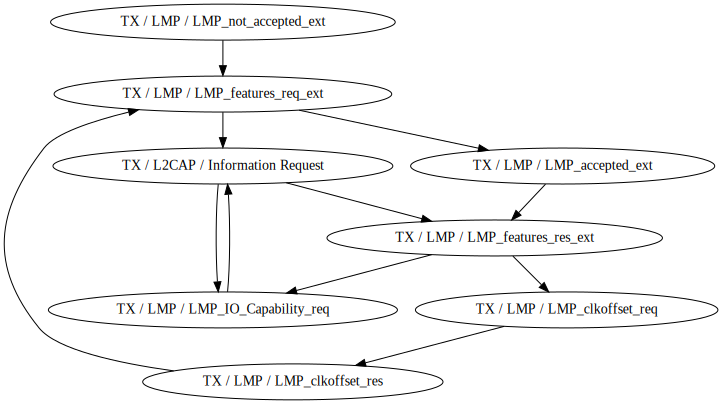

In [8]:
dot = graphviz.Digraph(comment="The Round Table")
unique_states = set()
for pkt in pkts[-12:]:
    unique_states.add(pkt["state"])
for i in unique_states:
    dot.node(i)

for pkt in pkts[-12:]:
    unique_states.add(pkt["state"])

prev_pkt = pkts[-12]
for pkt in pkts[-11:]:
    dot.edge(prev_pkt["state"], pkt["state"])
    prev_pkt = pkt

dot

In [40]:
ref_pkts = pkts[-15:]

for i, pkt in enumerate(pkts):
    if pkt["state"] == ref_pkts[0]["state"]:
        err_count = 0
        for ref_idx, ref_pkt in enumerate(ref_pkts):
            print(pkts[ref_idx + i]["state"])
            if ref_pkt["state"] != pkts[ref_idx + i]["state"]:
                err_count += 1
                if err_count >= 2:
                    break
        else:
            print(pkt)
        print()

TX / LMP / LMP_auto_rate
TX / LMP / LMP_packet_type_table_req
TX / LMP / LMP_max_slot
TX / LMP / LMP_auto_rate

TX / LMP / LMP_auto_rate
TX / LMP / LMP_packet_type_table_req
TX / LMP / LMP_not_accepted_ext
TX / LMP / LMP_accepted_ext

TX / LMP / LMP_auto_rate
TX / LMP / LMP_packet_type_table_req
TX / LMP / LMP_max_slot
TX / LMP / LMP_auto_rate

TX / LMP / LMP_auto_rate
TX / LMP / LMP_packet_type_table_req
TX / LMP / LMP_not_accepted_ext
TX / LMP / LMP_accepted_ext

TX / LMP / LMP_auto_rate
TX / LMP / LMP_max_slot
TX / LMP / LMP_packet_type_table_req

TX / LMP / LMP_auto_rate
TX / LMP / LMP_packet_type_table_req
TX / LMP / LMP_supervision_timeout
TX / LMP / LMP_not_accepted_ext
TX / LMP / LMP_accepted_ext
TX / LMP / LMP_clkoffset_req

TX / LMP / LMP_auto_rate
TX / LMP / LMP_max_slot
TX / LMP / LMP_packet_type_table_req

TX / LMP / LMP_auto_rate
TX / LMP / LMP_packet_type_table_req
TX / LMP / LMP_supervision_timeout
TX / LMP / LMP_not_accepted_ext
TX / LMP / LMP_features_req_ext
TX / LMP